# 2025 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

In [20]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader,Dataset
import transformers
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup

import colbert

from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert import Indexer, Searcher


from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [21]:
import os
os.chdir('Automated-Fact-checking-System')
print("Working space:", os.getcwd())


FileNotFoundError: [Errno 2] No such file or directory: 'Automated-Fact-checking-System'

# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [51]:
class ClaimEvidenceDataset(Dataset):

    def __init__(self, claims, evidence, tokenizer, max_len=512, if_train=True):
        self.claim_texts = []
        self.evidence_texts = []
        self.tokenizer = tokenizer
        self.max_length = max_len
        self.if_train = if_train
        if if_train:
            self.labels = []

        self.label2id = {
            "SUPPORTS": 0,
            "REFUTES": 1,
            "NOT_ENOUGH_INFO": 2,
            "DISPUTED": 3
        }

        if if_train:
            for claim_idx, claim_info in claims.items():
                self.claim_texts.append(claim_info['claim_text'])
                evidence_text = ""
                for evid in claim_info['evidences']:
                    if evid in evidence:
                        evidence_text += evidence[evid] + " "
                self.evidence_texts.append(evidence_text.strip())
                self.labels.append(self.label2id[claim_info['claim_label']])

        else:
            self.claim_texts.append(claims)
            print("claims", claims)
            self.evidence_texts.append(evidence)
            print("evidence", evidence)
            
    def __len__(self):
        return len(self.claim_texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.claim_texts[idx],
            self.evidence_texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        if self.if_train:
            return {
                'input_ids': encoded['input_ids'].squeeze(0),
                'attention_mask': encoded['attention_mask'].squeeze(0),
                'labels': torch.tensor(self.labels[idx], dtype=torch.long)
            }
        else:
            return {
                'input_ids': encoded['input_ids'].squeeze(0),
                'attention_mask': encoded['attention_mask'].squeeze(0),
            }


In [30]:
with open("data/train-claims.json", 'r') as f:
    train_claims = json.load(f)

with open("data/test-claims-unlabelled.json", 'r') as f:
    test_claims = json.load(f)

with open("data/evidence.json", 'r') as f:
    evidence = json.load(f)

with open("data/evidence.json", "r") as f:
    data = json.load(f)

with open('data/evidence_colbert.tsv', 'w', encoding='utf-8') as f_out:
    for idx, text in enumerate(data.values()):
        text = text.replace("\t", " ")
        f_out.write(f"{idx}\t{text.strip()}\n")


# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
#only run once(I have run it), if you want to re-index, set overwrite=True
#Indexing, Tokenization and embedding in evidence_colbert.txt
checkpoint = "colbert-ir/colbertv2.0"
index_name = "evidence_index"
doc_maxlen = 180

with Run().context(RunConfig(nranks=1, experiment="colab_run", root="./colbert")):
    config = ColBERTConfig(nbits=2, root="./colbert")
    indexer = Indexer(checkpoint=checkpoint, config=config)
    #indexer.index(name=index_name, collection="data/evidence_colbert.tsv",overwrite=True)
    indexer.index(name=index_name, collection="data/evidence_colbert.tsv")

In [ ]:
#Roberta Model setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4).to(device)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
#tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
#model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=4).to(device)

epochs = 24

batch_size = 32

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scaler = torch.cuda.amp.GradScaler()#accelerate

train_steps = int((len(train_claims) * epochs)/batch_size)
num_steps = int(train_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

train_dataset = ClaimEvidenceDataset(train_claims, evidence, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

#valid_dataset = ClaimEvidenceDataset(test_claims, evidence, tokenizer, if_train = False)
#valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=True)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
#freeze last 3 layer
for param in model.parameters():
    param.requires_grad = False

for layer in model.roberta.encoder.layer[-3:]:
    for param in layer.parameters():
        param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True


In [37]:
def training(train_dataloader, model, optimizer, scheduler, scaler, device):
    model.train()
    correct_predictions = 0
    total_loss = 0
    num_batches = 0
    total_samples = 0

    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(ids, attention_mask=mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

        preds = torch.argmax(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        num_batches += 1

    avg_epoch_loss = total_loss / num_batches
    accuracy = correct_predictions / total_samples

    return avg_epoch_loss, accuracy


def validating(val_dataloader, model, device):
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)

            outputs = model(ids, attention_mask=mask)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1)
            all_predictions.extend(preds.cpu().tolist())  # 转为 Python list 加入结果

    return all_predictions
    


Epoch 1/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:12<00:00,  3.23it/s]


Train Loss: 1.3889
Train Accuracy: 0.2777
Epoch 2/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.43it/s]


Train Loss: 1.2868
Train Accuracy: 0.4145
Epoch 3/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.44it/s]


Train Loss: 1.1824
Train Accuracy: 0.5342
Epoch 4/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.44it/s]


Train Loss: 0.9701
Train Accuracy: 0.6189
Epoch 5/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.33it/s]


Train Loss: 0.9245
Train Accuracy: 0.6262
Epoch 6/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.41it/s]


Train Loss: 0.8328
Train Accuracy: 0.6669
Epoch 7/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.35it/s]


Train Loss: 0.8053
Train Accuracy: 0.6702
Epoch 8/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.27it/s]


Train Loss: 0.7494
Train Accuracy: 0.6922
Epoch 9/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.40it/s]


Train Loss: 0.7174
Train Accuracy: 0.7028
Epoch 10/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.50it/s]


Train Loss: 0.6713
Train Accuracy: 0.7256
Epoch 11/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.48it/s]


Train Loss: 0.6310
Train Accuracy: 0.7394
Epoch 12/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.39it/s]


Train Loss: 0.5853
Train Accuracy: 0.7638
Epoch 13/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.45it/s]


Train Loss: 0.5550
Train Accuracy: 0.7663
Epoch 14/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.40it/s]


Train Loss: 0.5122
Train Accuracy: 0.7997
Epoch 15/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.47it/s]


Train Loss: 0.4567
Train Accuracy: 0.8192
Epoch 16/24
----------


  5%|███████▊                                                                                                                                                | 2/39 [00:00<00:10,  3.48it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.47it/s]


Train Loss: 0.4591
Train Accuracy: 0.8249
Epoch 17/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.44it/s]


Train Loss: 0.4332
Train Accuracy: 0.8314
Epoch 18/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.44it/s]


Train Loss: 0.4110
Train Accuracy: 0.8282
Epoch 19/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.44it/s]


Train Loss: 0.3876
Train Accuracy: 0.8632
Epoch 20/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.43it/s]


Train Loss: 0.3814
Train Accuracy: 0.8575
Epoch 21/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.40it/s]


Train Loss: 0.3520
Train Accuracy: 0.8762
Epoch 22/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.37it/s]


Train Loss: 0.3578
Train Accuracy: 0.8673
Epoch 23/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.44it/s]


Train Loss: 0.3544
Train Accuracy: 0.8705
Epoch 24/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.40it/s]
/tmp/ipykernel_19706/1707275082.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, train_losses_list, 'bo-', label="Training Loss", color='blue')


Train Loss: 0.3424
Train Accuracy: 0.8819


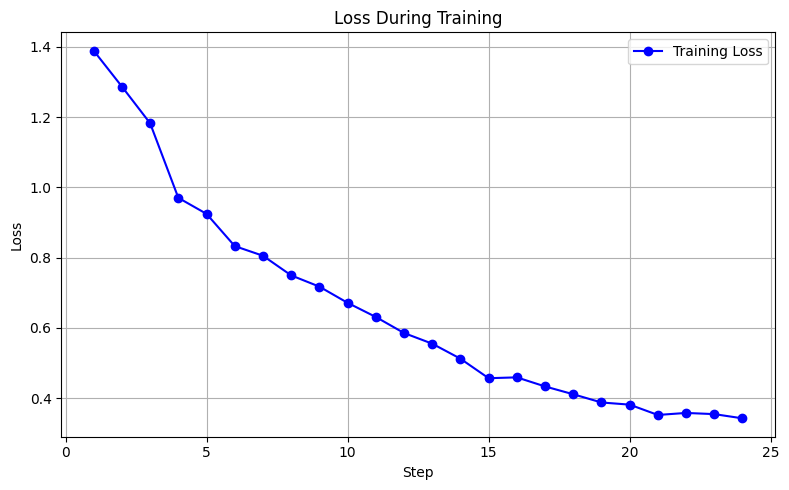

/tmp/ipykernel_19706/1707275082.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy', color='green')


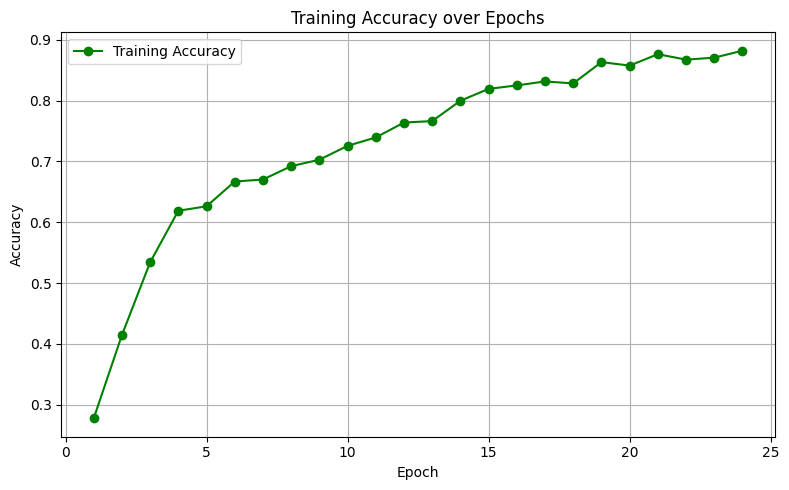

In [28]:
train_losses_list = []
train_accuracies = []

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    train_loss, accuracy = training(train_dataloader, model, optimizer, scheduler, scaler, device)

    print(f'Train Loss: {train_loss:.4f}')
    print(f'Train Accuracy: {accuracy:.4f}')
    train_losses_list.append(train_loss)
    train_accuracies.append(accuracy)

epochs = range(1, len(train_accuracies) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses_list, 'bo-', label="Training Loss", color='blue')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss During Training")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [49]:
print("Working space:", os.getcwd())
searcher = Searcher(index=index_name, checkpoint=checkpoint, index_root="colbert/colab_run/indexes")

def retrieve(claim, k=5):
  with torch.no_grad():
      doc_ids, rank, scores = searcher.search(claim, k=k)
      retrieved_text = " ".join([
        searcher.collection[doc_id].replace("\n", " ").strip()
        for doc_id in doc_ids
      ])
      return retrieved_text

claim = "The actual data show high northern latitudes are warmer today than in 1940"
retrieved_evidence = retrieve(claim)

print(retrieved_evidence)

Working space: /home/lhg45/ColBERT/Automated-Fact-checking-System
[May 10, 14:48:17] #> Loading collection...
0M 1M 
[May 10, 14:48:22] #> Loading codec...
[May 10, 14:48:22] #> Loading IVF...
[May 10, 14:48:22] #> Loading doclens...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 1852.76it/s]

[May 10, 14:48:22] #> Loading codes and residuals...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 103.79it/s]



#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: The actual data show high northern latitudes are warmer today than in 1940, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  1996,  5025,  2951,  2265,  2152,  2642, 15250,  2015,
         2024, 16676,  2651,  2084,  1999,  3878,   102,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

If high latitude waters are warmer than 5 °C (41 °F), their density is too low for them to sink below the cooler deep waters. The report stated (p. 36) that, "The average surface air temperature in the northern hemisphere increased from the 1880's until about 1940 and has been decreasing thereafter. Multiple independently produced instrumental data

In [54]:
valid_dataset = ClaimEvidenceDataset(claim, retrieved_evidence, tokenizer, if_train = False)
valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=True)

id2label = {
    0: "SUPPORTS",
    1: "REFUTES",
    2: "NOT_ENOUGH_INFO",
    3: "DISPUTED"
}

predictions = validating(valid_dataloader, model, device)
label_names = [id2label[p] for p in predictions]
print(label_names)

claims The actual data show high northern latitudes are warmer today than in 1940
evidence If high latitude waters are warmer than 5 °C (41 °F), their density is too low for them to sink below the cooler deep waters. The report stated (p. 36) that, "The average surface air temperature in the northern hemisphere increased from the 1880's until about 1940 and has been decreasing thereafter. Multiple independently produced instrumental datasets confirm that the 2009–2018 decade was 0.93 ± 0.07 °C warmer than the pre-industrial baseline (1850–1900). The authors concluded that "Northern Hemisphere mean annual temperatures for three of the past eight years are warmer than any other year since (at least) AD1400", and estimated empirically that greenhouse gases had become the dominant climate forcing during the 20th century. In the higher latitudes, the North Atlantic Drift, warms the atmosphere over the oceans, keeping the British Isles and north-western Europe mild and cloudy, and not severe

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.45it/s]

['NOT_ENOUGH_INFO']


## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*